In [1]:
%%time
from configure import GlobalVariable
gvar = GlobalVariable()

loading data...
end of loading
end of init
CPU times: user 1min 35s, sys: 26.4 s, total: 2min 2s
Wall time: 2min 8s


In [2]:
%reload_ext autoreload
% autoreload 2

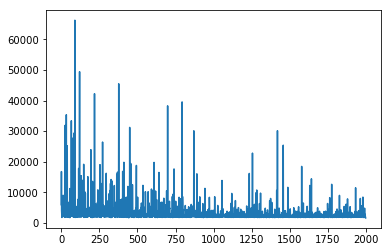


  1.6951
  4.7769
  1.1474
   ⋮    
  0.5556
  0.5505
  0.4657
[torch.FloatTensor of size 1999]

[ 0.42492369  0.15078183  0.62774016 ...,  1.29632203  1.30838707
  1.54671186]


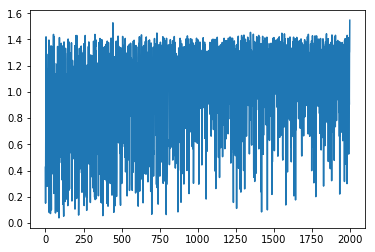


 0.4249
 0.1508
 0.6277
   ⋮   
 1.2963
 1.3084
 1.5467
[torch.FloatTensor of size 1999]



In [6]:
from matplotlib import pyplot as plt
plt.plot(range(1999), gvar.class_weights)
plt.show()

import torch
weight = torch.from_numpy(gvar.class_weights.astype('float') / gvar.class_weights.sum()).float() * gvar.n_classes
print weight

weights = gvar.class_weights.sum() / gvar.class_weights.astype('float')
weights = weights / weights.sum() * gvar.n_classes
print weights

plt.plot(range(1999), weights)
plt.show()

weights = torch.from_numpy(weights).float()
print weights

In [34]:
def train(epoch):
    epoch_train_loss = []
    batchid = 0
    for inputs, targets in dataset_train.next_batch():
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        # clip for rnn ?
        optimizer.step()
        loss = loss.data.mean()
        epoch_train_loss.append(loss)
        batchid += 1
        #print 'epoch = %d, batch id = %d, train loss = %.3f' % (epoch, batchid, loss)
        if batchid > 20:
            break
    epoch_train_loss = np.array(epoch_train_loss).mean()
    return epoch_train_loss


def validate(epoch):
    epoch_val_loss = []
    batchid = 0
    for inputs, targets in dataset_val.next_batch():
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss = loss.data.mean()
        epoch_val_loss.append(loss)
        batchid += 1
        #print 'epoch = %d, batch id = %d, evaluation loss = %.3f' % (epoch, batchid, loss)
        if batchid > 2:
            break
    epoch_val_loss = np.array(epoch_val_loss).mean()
    return epoch_val_loss

In [42]:
import torch
import torch.nn as nn
import numpy as np
from model import TextModelModule
from zutil.config import Config

config  = Config('parameter.json', model_type='baseline')
model = TextModelModule(config)
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = config.learning_rate)

if config.gpu:
    model = model.cuda()
    criterion = criterion.cuda()

print model
print config

from data import QuestionDataset
dataset_train = QuestionDataset(config.copy(mode='train'), gvar)
dataset_val = QuestionDataset(config.copy(mode='val'), gvar)

from hyperboard import Agent
agent = Agent(address='localhost', port=5000)

train_agent = agent.register({'loss':'train'}, 'loss', overwrite=True)
valid_agent = agent.register({'loss':'valid'}, 'loss', overwrite=True)

print agent

TextModelModule (
  (mlp): Sequential (
    (0): Linear (512 -> 1024)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU ()
    (3): Linear (1024 -> 1024)
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU ()
    (6): Linear (1024 -> 1024)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU ()
    (9): Linear (1024 -> 1999)
  )
)
{u'n_classes': 1999, u'max_qlen': 55, u'max_epoch': 50, u'learning_rate': 0.001, u'mlp_hidden_size': 1024, u'rnn_hidden_size': 300, u'batch_size': 200, u'split_rate': 0.9, u'emb_dim': 256, u'nothing': u'_', u'mode': u'train', u'question_type': u'title', u'model_type': 'baseline', u'gpu': True, u'rnn_hidden_layers': 3}
<hyperboard.agent.Agent instance at 0x7f06e36b0b90>


In [43]:
def main_loop():
    for epoch in range(config.max_epoch * 10):
        model.train()
        train_loss = train(epoch)
        model.eval()
        valid_loss = validate(epoch)
        
        if epoch > 5:
            agent.append(train_agent, epoch, train_loss)
            agent.append(valid_agent, epoch, valid_loss)
        
        print 'epoch = {}, train loss = {}, valid loss = {}'.format(epoch, train_loss, valid_loss)
        
main_loop()

epoch = 0, train loss = 0.216790810582, valid loss = 0.130949795246
epoch = 1, train loss = 0.0180201816949, valid loss = 0.0108026942859
epoch = 2, train loss = 0.010927256862, valid loss = 0.0107718414317
epoch = 3, train loss = 0.00975348117451, valid loss = 0.00970127681891
epoch = 4, train loss = 0.00920744311242, valid loss = 0.0090323354428
epoch = 5, train loss = 0.00889668046009, valid loss = 0.00844430706153
epoch = 6, train loss = 0.0085286032852, valid loss = 0.00830762150387
epoch = 7, train loss = 0.00857902074321, valid loss = 0.00850869528949
epoch = 8, train loss = 0.0084415847613, valid loss = 0.0080256331712
epoch = 9, train loss = 0.00827907407213, valid loss = 0.00829540534566
epoch = 10, train loss = 0.00820049714474, valid loss = 0.00803195747236
epoch = 11, train loss = 0.00809315742836, valid loss = 0.00812861416489
epoch = 12, train loss = 0.00810106717316, valid loss = 0.00769799963261
epoch = 13, train loss = 0.00784483833593, valid loss = 0.00768587055306
e

In [49]:
import time
checkpoint = {
    'config' : config,
    'model' : model,
    'time' : time.ctime()
}
torch.save(checkpoint, 'checkpoint.pt')